# Reddit Text Data Moddeling 

### Introduction
This document aims to analyze and explore the top 100 Reddit posts per day from the main subreddits dedicated to Bitcoin (BTC), Ethereum (ETH), and Solana (SOL). The primary goal is to extract time series features that can be incorporated into a machine learning algorithm. The focus will be on extracting sentiment, emotions, and topics over time.

### Objectives
- Data Collection:
Gather the top 100 Reddit posts per day from BTC, ETH, and SOL subreddits.

- Data Exploration: 
Sift through the data to pull meaningful insights

- Feature Extraction:
Extract sentiment, emotion, and topic features from the text data.

- Time Series Analysis:
Analyze the extracted features over time to create time series data.

### Importing necessary libraries and setting up enviornment

In [1]:
import pandas as pd

# Text Processing Libraries 
from nltk.corpus import stopwords
import nltk
from nltk import bigrams, trigrams 
from nltk import word_tokenize
import spacy 
import string 

from sklearn.feature_extraction.text import TfidfVectorizer


from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.util import ngrams # Making BiGrams and TriGrams
from collections import Counter

from sklearn.decomposition import NMF # Topic modelling



#### Loading the Text Datasets

In [4]:
btc_text, eth_text, sol_text = pd.read_csv('data/reddit/BTC_R.csv'), pd.read_csv('data/reddit/ETH_R.csv'), pd.read_csv('data/reddit/SOL_R.csv')
btc_text.date_posted, eth_text.date_posted, sol_text.date_posted = pd.to_datetime(btc_text.date_posted), pd.to_datetime(eth_text.date_posted), pd.to_datetime(sol_text.date_posted)
btc_text

,subreddit,title,selftext,upvote_ratio,ups,downs,score,comments,date_posted,pull_date
0,Bitcoin,Bitcoin Newcomers FAQ - Please read!,# Welcome to the /r/Bitcoin Newcomers FAQ\n\nY...,0.95,194,0,194,148,2023-09-06,08:07.5
1,Bitcoin,Are you still DCAing?,Or are you waiting for lower prices?,0.76,45,0,45,95,2024-02-05,08:07.5
2,Bitcoin,What happens if there are no miners at all?,Not really a relevant question as I can guaran...,0.37,0,0,0,35,2024-02-05,08:07.5
3,Bitcoin,Where can I Download full node bitcoin ledger ...,"Hi, have some experience running bitcoin core ...",0.64,7,0,7,39,2024-02-04,08:07.6
4,Bitcoin,Need good basic Spanish BTC video to convice m...,I am a big believer in BTC. It will slowly con...,0.67,10,0,10,38,2024-02-04,08:07.6
...,...,...,...,...,...,...,...,...,...,...
13526,Bitcoin,Bitcoin Optech 307 Podcast: Murch &amp; Mike S...,NaN,0.85,10,0,10,0,2024-06-27,2024-06-29 00:00:00
13527,Bitcoin,Bitcoin Mining Isn’t Driving Texas Power Demand,The mining sector is no exception to the rule ...,0.82,22,0,22,18,2024-06-27,2024-06-29 00:00:00
13528,Bitcoin,Faced With the Demagoguery of Politicians Ever...,NaN,0.94,17,0,17,1,2024-06-27,2024-06-29 00:00:00
13529,Bitcoin,Bitcoin is my life raft,I write this here because no one I know unders...,0.90,400,0,400,286,2024-06-26,2024-06-29 00:00:00


#### Counting the number of posts per date_posted

In [3]:
def create_date_count_table(df, date_column):
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    
    # Drop rows with missing or NaT (Not a Time) values
    df = df.dropna(subset=[date_column])
    
    # Extract month and day from the date
    df['month'] = df[date_column].dt.month
    df['day'] = df[date_column].dt.day
    
    # Group by month and day, count rows
    pivot_table = df.groupby(['month', 'day']).size().unstack(fill_value=0)
    
    return pivot_table

date_count_table = create_date_count_table(btc_text, 'date_posted')
date_count_table

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
month,,,,,,,,,,,,,,,,,,,,,
1,0,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,4,33,89,95,88,95,26,122,...,99,120,88,84,110,72,114,125,0,0
3,70,99,101,94,147,80,64,169,146,75,...,71,116,89,129,94,116,99,85,115,137
4,43,79,94,98,81,70,85,64,114,97,...,53,132,116,123,79,70,98,60,63,0
5,104,53,71,67,86,97,79,40,10,19,...,114,103,84,74,43,96,132,87,104,90
6,84,120,94,98,92,117,118,96,100,90,...,75,71,93,97,50,111,84,49,15,0
9,0,0,0,0,0,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Pre-Proccessing the Text

In [8]:
# Download NLTK stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load spaCy's small English model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize text using spaCy's nlp pipeline
    tokens = nlp(text)
    
    # Remove stop words and non-alphabetic tokens, and perform lemmatization
    tokens = [token.lemma_ for token in tokens if token.is_alpha and token.text not in stop_words]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

btc_text['selftext_p'] = btc_text['selftext'].apply(preprocess_text)
btc_text['title_p'] = btc_text['title'].apply(preprocess_text)
btc_text['text_p'] = btc_text['title_p'] + ' ' + btc_text['selftext_p']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mulle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Making a TF-IDF Matrix 

###### TF-IDF, or Term Frequency-Inverse Document Frequency, is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (or corpus). The term frequency (TF) counts how often a word appears in a document, while the inverse document frequency (IDF) reduces the weight of words that appear frequently across many documents, thus highlighting words that are more unique to the specific document. The TF-IDF score is the product of these two metrics, helping to identify words that are both frequent in the document and unique across the corpus, making it useful for tasks like information retrieval, text mining, and natural language processing.

In [9]:
# Making TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(btc_text['text_p']).toarray()

# Convert to dataframe with the word names as well 
tfidf_df = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

# Sort the DataFrame columns by their sum in descending order
sorted_columns = tfidf_df.sum().sort_values(ascending=False).index
tfidf_df = tfidf_df[sorted_columns]
tfidf_df.head(5)

,bitcoin,btc,buy,wallet,not,get,year,use,go,would,...,hardware,create,link,answer,per,card,security,user,secure,resource
0,0.629538,0.033016,0.058219,0.232085,0.058325,0.022747,0.025897,0.198783,0.037342,0.048845,...,0.134011,0.071538,0.115672,0.069591,0.116375,0.120738,0.178226,0.122484,0.141221,0.151363
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.208793,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.366829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.232898,0.252430,0.000000,0.147870,0.000000,0.130438,0.000000,0.142484,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


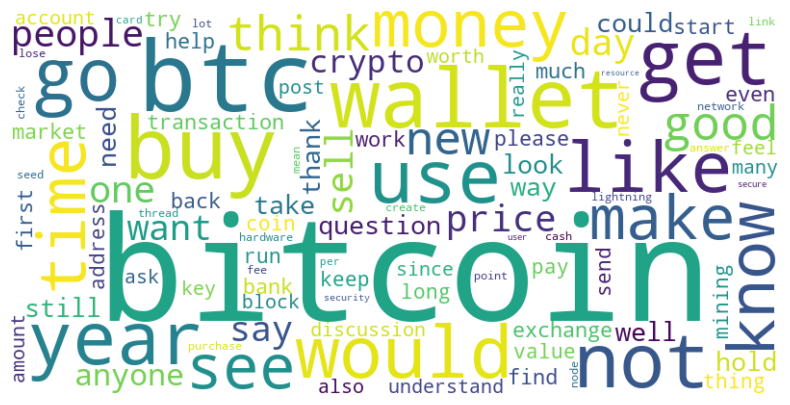

In [10]:
tfidf_scores = tfidf_df.sum(axis=0).to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

###### **Buy and Sell:** These words highlight the transactional aspect of Bitcoin, where users are frequently discussing buying and selling activities. This is indicative of Bitcoin's use as an investment or trading asset.

###### **Know, Think, See, and Understand:** These words suggest that the text contains a lot of discussions about understanding Bitcoin, sharing opinions, and gaining knowledge about how it works and its potential.

###### **Make, Get, Use, and Take:** These action words imply discussions around how to utilize Bitcoin, ways to earn or acquire it, and different uses for the cryptocurrency.

### Making Bigrams and Trigrams

###### Bigrams and trigrams are types of n-grams, which are contiguous sequences of n items from a given text or speech. In the context of natural language processing (NLP), bigrams are pairs of consecutive words, while trigrams are sequences of three consecutive words. The purpose of using bigrams and trigrams is to capture context and relationships between words that are lost when considering single words (unigrams) in isolation. This helps in understanding the structure and meaning of the text more accurately.

In [11]:
btc_text['text_p'] = btc_text['text_p'].fillna('').astype(str)


def generate_ngrams(text, n):
    # Tokenize the text into words
    words = word_tokenize(text.lower())  # Convert to lower case
    # Generate n-grams
    return list(ngrams(words, n))

# Applying the function to each post and creating bigrams and trigrams
btc_text['bigrams'] = btc_text['text_p'].apply(lambda x: generate_ngrams(x, 2))
btc_text['trigrams'] = btc_text['text_p'].apply(lambda x: generate_ngrams(x, 3))

# Flatten the list of bigrams and trigrams and count occurrences
all_bigrams = [bigram for sublist in btc_text['bigrams'] for bigram in sublist]
bigram_counts = Counter(all_bigrams)
most_common_bigrams = bigram_counts.most_common(30)

all_trigrams = [trigram for sublist in btc_text['trigrams'] for trigram in sublist]
trigram_counts = Counter(all_trigrams)
most_common_trigrams = trigram_counts.most_common(30)

# Creating a DataFrame from the most common bigrams and trigrams
Grams = pd.DataFrame({
    'Bigram': [bigram for bigram, count in most_common_bigrams[:20]],
    'Trigram': [trigram for trigram, count in most_common_trigrams[:20]]
})

Grams.head(5)

,Bigram,Trigram
0,"(hardware, wallet)","(physical, security, key)"
1,"(buy, bitcoin)","(please, utilize, sticky)"
2,"(open, source)","(utilize, sticky, thread)"
3,"(third, party)","(sticky, thread, general)"
4,"(can, not)","(thread, general, bitcoin)"


### Topic Modelling: NMF

In [31]:
# Fit the NMF model
num_topics = 4
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(X)

# Assign topics to documents
topic_values = nmf_model.transform(X)
btc_text['topic_nmf'] = topic_values.argmax(axis=1)

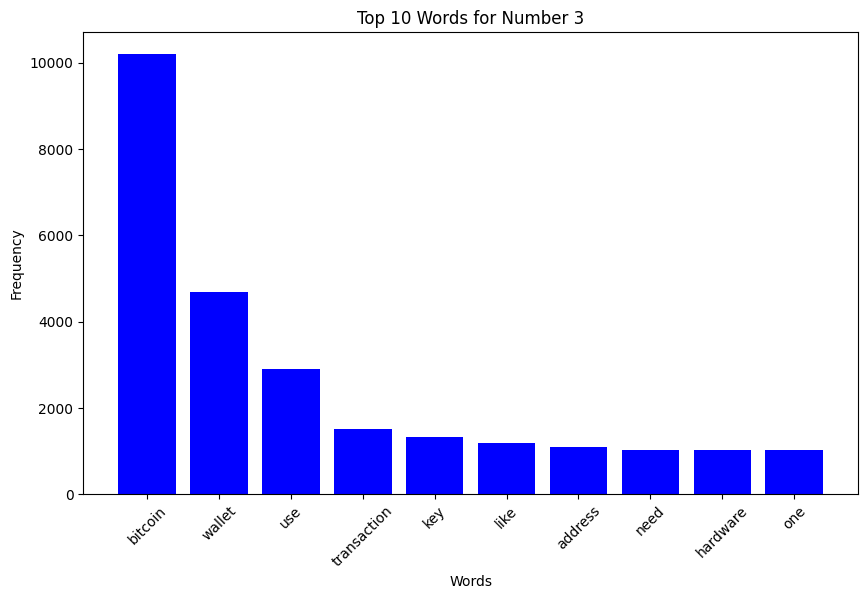

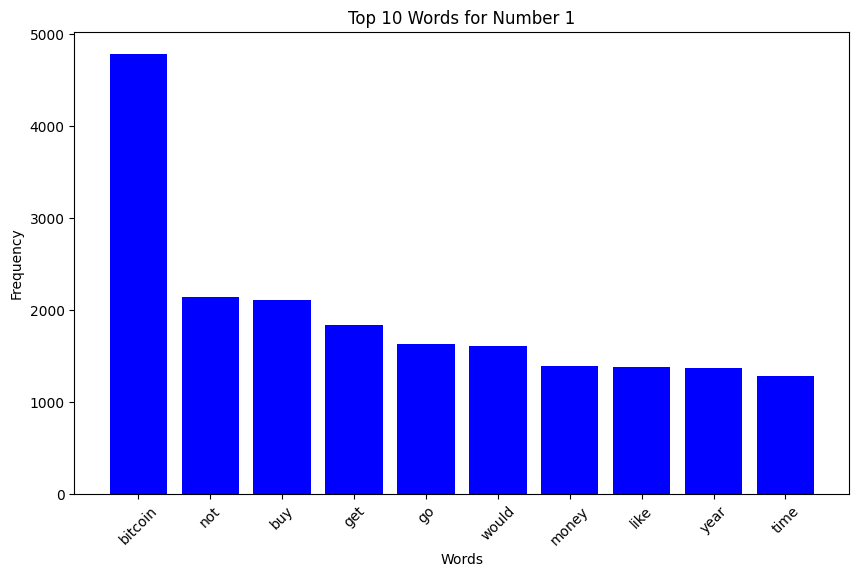

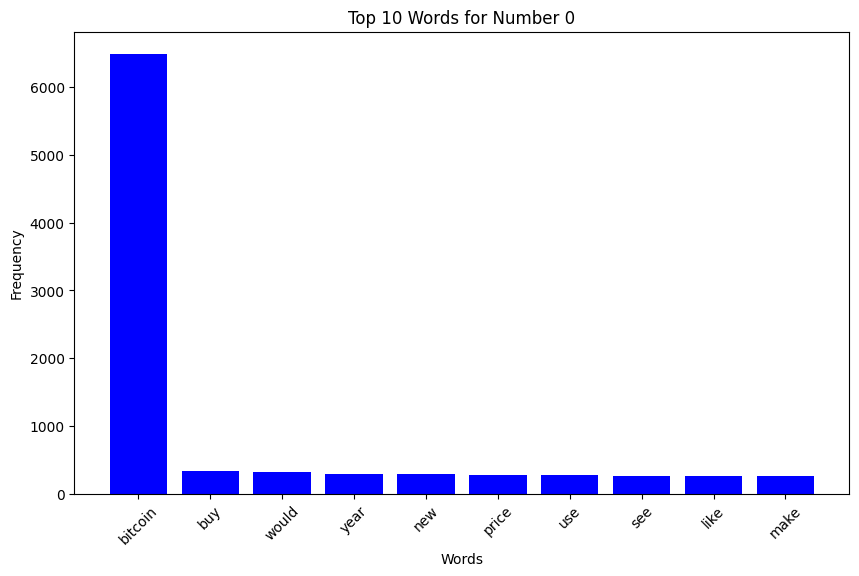

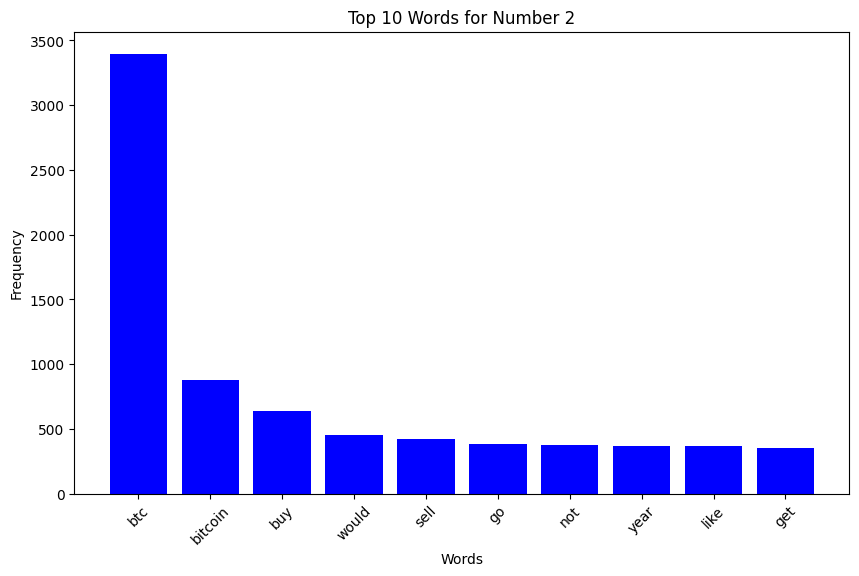

In [32]:
# Function to get top N words for each number
def get_top_words(df, number, top_n=10):
    text_data = df[df['topic_nmf'] == number]['text_p'].tolist()
    all_words = [word for sublist in text_data for word in sublist.split()]
    word_counts = Counter(all_words)
    top_words = word_counts.most_common(top_n)
    return top_words

# Automatically detect distinct numbers
distinct_numbers = btc_text['topic_nmf'].unique()

# Create bar charts for top 10 words for each number
for number in distinct_numbers:
    top_words = get_top_words(btc_text, number)
    
    if not top_words:
        print(f"No words to display for number {number}")
        continue
    
    words, counts = zip(*top_words)
    
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='blue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Words for Number {number}')
    plt.xticks(rotation=45)
    plt.show()

### Running sentiment analysis with VADER method

In [12]:
import nltk
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import mark_negation

# Download necessary NLTK corpora and models
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to apply sentiment analysis
def apply_sentiment_analysis(text):
    if pd.isna(text):
        # Return a neutral sentiment score for NaN entries
        return {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
    return sia.polarity_scores(text)

# Apply sentiment analysis to each row in the DataFrame
btc_text['Sentiment'] = btc_text['text_p'].apply(apply_sentiment_analysis)
btc_text['Sentiment_All'] = btc_text['Sentiment'].apply(lambda x: x['compound'])

btc_text.head(3)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mulle\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,subreddit,title,selftext,upvote_ratio,ups,downs,score,comments,date_posted,pull_date,selftext_p,title_p,text_p,bigrams,trigrams,Sentiment,Sentiment_All
0,Bitcoin,Bitcoin Newcomers FAQ - Please read!,# Welcome to the /r/Bitcoin Newcomers FAQ\n\nY...,0.95,194,0,194,148,2023-09-06,08:07.5,welcome rbitcoin newcomer faq probably hear lo...,bitcoin newcomer faq please read,bitcoin newcomer faq please read welcome rbitc...,"[(bitcoin, newcomer), (newcomer, faq), (faq, p...","[(bitcoin, newcomer, faq), (newcomer, faq, ple...","{'neg': 0.067, 'neu': 0.752, 'pos': 0.181, 'co...",0.9995
1,Bitcoin,Are you still DCAing?,Or are you waiting for lower prices?,0.76,45,0,45,95,2024-02-05,08:07.5,wait low price,still dcae,still dcae wait low price,"[(still, dcae), (dcae, wait), (wait, low), (lo...","[(still, dcae, wait), (dcae, wait, low), (wait...","{'neg': 0.344, 'neu': 0.656, 'pos': 0.0, 'comp...",-0.2732
2,Bitcoin,What happens if there are no miners at all?,Not really a relevant question as I can guaran...,0.37,0,0,0,35,2024-02-05,08:07.5,really relevant question guarantee never time ...,happen miner,happen miner really relevant question guarante...,"[(happen, miner), (miner, really), (really, re...","[(happen, miner, really), (miner, really, rele...","{'neg': 0.222, 'neu': 0.548, 'pos': 0.23, 'com...",0.3243


In [29]:
btc_text['full_text'] = btc_text['title'] + [''] + btc_text['selftext']

#### Grouping the Sentiment by Date (To have a timeseries sentiment feature to plug into main model)

In [13]:
btc_reddit = btc_text[['date_posted','Sentiment_All','ups','comments']]
btc_reddit['Weight'] = btc_reddit.ups * btc_reddit.comments
btc_reddit = btc_reddit[['date_posted','Sentiment_All','Weight']]

btc_reddit = btc_reddit.groupby('date_posted').apply(
    lambda x: (x['Weight'] * x['Sentiment_All']).sum() / x['Weight'].sum()
).reset_index(name='weighted_sentiment')

btc_reddit

C:\Users\mulle\AppData\Local\Temp\ipykernel_15848\3373916266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_reddit['Weight'] = btc_reddit.ups * btc_reddit.comments


,date_posted,weighted_sentiment
0,2023-06-09,0.999500
1,2023-09-06,0.999500
2,2024-01-03,0.440400
3,2024-02-03,-0.618639
4,2024-02-04,0.372207
...,...,...
146,2024-06-26,0.220186
147,2024-06-27,0.335465
148,2024-06-28,0.241396
149,2024-06-29,-0.239932


###### Graphing the Reddit sentiment scores over time

Text(0, 0.5, 'VADER Sentiment')

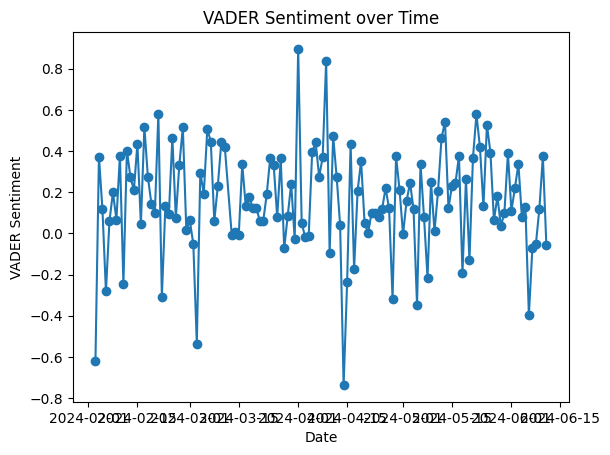

In [36]:
btc_reddit.date_posted = pd.to_datetime(btc_reddit.date_posted)
btc_reddit = btc_reddit[btc_reddit['date_posted'].dt.year == 2024]
btc_reddit = btc_reddit[btc_reddit['date_posted'].dt.month >= 2]
plt.plot(btc_reddit['date_posted'], btc_reddit['weighted_sentiment'], marker='o')
plt.title('VADER Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('VADER Sentiment')


In [14]:
btc_reddit

,date_posted,weighted_sentiment
0,2023-06-09,0.999500
1,2023-09-06,0.999500
2,2024-01-03,0.440400
3,2024-02-03,-0.618639
4,2024-02-04,0.372207
...,...,...
146,2024-06-26,0.220186
147,2024-06-27,0.335465
148,2024-06-28,0.241396
149,2024-06-29,-0.239932


### Making sentiment analysis using a transformer model (pre-trained)

Model Used: Hugging Face [ProsusAI]

Link: https://huggingface.co/ProsusAI/finbert

****** Work in Progress ******
30th June: Got the code to work and run a transformer model using GPU to classifiy Bearish, Neutral, and Bullish. 
Problem: A lot of neutral, doesn't give a lot of information. A continious scale would be more informative

In [47]:
import pandas as pd
import torch
from transformers import pipeline, BertTokenizer

# Choose a model for sentiment analysis
model_name = "ProsusAI/finbert"
device = "cuda" if torch.cuda.is_available() else "cpu"
nlp = pipeline("sentiment-analysis", model=model_name, device=device)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Function to split text into chunks
def split_into_chunks(text, max_length=510):
    # Convert to string if not already
    text = str(text)
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0

    for word in words:
        word_tokens = tokenizer.tokenize(word)
        word_length = len(word_tokens)

        if current_length + word_length <= max_length:
            current_chunk.append(word)
            current_length += word_length
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_length = word_length

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

# Function to classify sentiment
def classify_sentiment(text):
    # Convert to string if not already
    text = str(text)
    chunks = split_into_chunks(text)
    sentiments = []
    strengths = []
    
    for chunk in chunks:
        result = nlp(chunk)[0]
        
        label = result['label']
        score = result['score']
        
        if label == "positive":
            sentiment = "bullish"
        elif label == "negative":
            sentiment = "bearish"
        else:
            sentiment = "neutral"
        
        sentiments.append(sentiment)
        strengths.append(score)
    
    # Aggregate results
    final_sentiment = max(set(sentiments), key=sentiments.count) if sentiments else "neutral"
    avg_strength = sum(strengths) / len(strengths) if strengths else 0.0
    
    return final_sentiment, avg_strength

In [48]:
btc_text[['sentiment_tt', 'strength_tt']] = btc_text['full_text'].apply(lambda x: pd.Series(classify_sentiment(x)))

In [50]:
btc_reddit

,date_posted,weighted_sentiment
0,2023-06-09,0.999500
1,2023-09-06,0.999500
2,2024-01-03,0.440400
3,2024-02-03,-0.618639
4,2024-02-04,0.372207
...,...,...
146,2024-06-26,0.220186
147,2024-06-27,0.335465
148,2024-06-28,0.241396
149,2024-06-29,-0.239932


In [51]:
btc_reddit.to_csv('data/model/btc_reddit_sen.csv')